# Estimate annual glacier areas

In [33]:
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import ee
import geedim as gd
import wxee
import datetime
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
from tqdm import tqdm

# Define path to dataset for convenience
data_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/'

## Authenticate and/or Initialize Google Earth Engine

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

## Load compiled glacier boundaries

In [3]:
# Define root path to data for convenience
scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'

# Define output directory
out_path = os.path.join(scm_path, 'analysis')

# Load AOIs
aois_fn = os.path.join(out_path, 'AOIs.gpkg')
aois = gpd.read_file(aois_fn)
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
print('All glacier boundaries loaded from file.')

All glacier boundaries loaded from file.


## Define processing functions

In [73]:
# Define function to solve for optimal UTM zone
def convert_wgs_to_utm(lon: float, lat: float):
    """
    Return best UTM epsg-code based on WGS84 lat and lon coordinate pair

    Parameters
    ----------
    lon: float
        longitude coordinate
    lat: float
        latitude coordinate

    Returns
    ----------
    epsg_code: str
        optimal UTM zone, e.g. "EPSG:32606"
    """
    utm_band = str(int((np.floor((lon + 180) / 6) % 60) + 1))
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = 'EPSG:326' + utm_band
        return epsg_code
    epsg_code = 'EPSG:327' + utm_band
    return epsg_code

# Define function to check classified images for debris cover
def estimate_glacier_debris_areas(aoi, classified_folder, crs=None, plot_ts=True):
    # get classified image file names
    classified_fns = sorted(glob.glob(os.path.join(classified_folder, '*.nc')))

    # initialize debris variable
    glacier_area_list = []
    debris_area_list = []
    total_area_list = []
    dts_list = []

    # identify optimal UTM zone for better area calculations
    if crs is None:
        aoi = aoi.to_crs("EPSG:4326")
        aoi_centroid = aoi.geometry[0].centroid.coords.xy[0][0], aoi.geometry[0].centroid.coords.xy[1][0]
        crs = convert_wgs_to_utm(aoi_centroid[0], aoi_centroid[1])
        print('Optimal UTM zone =', crs)

    # iterate over classified images
    for fn in tqdm(classified_fns):
        # get image datetime from file name
        dts_list += [datetime.datetime.strptime(os.path.basename(fn).split('_')[0], '%Y%m%dT%H%M%S')]
        # open classified image
        im = rxr.open_rasterio(fn).squeeze()
        im = im.rio.reproject(crs)
        im = xr.where(im==-9999, np.nan, im)
        im_res = im.rio.resolution()[0]
        # calculate glacier area (==1, 2, 3)
        glacier_area_list += [im.where(im.isin([1, 2, 3])).count().values * im_res**2]
        # calculate debris area (==5)
        debris_area_list += [im.where(im==5).count().values * im_res**2]
        # identify area with real values
        total_area_list += [im.where(~np.isnan(im)).count().values * im_res**2]
    
    # compile in dataframe
    df = pd.DataFrame({'datetime': dts_list, 
                       'glacier_area_m2': glacier_area_list,
                       'debris_area_m2': debris_area_list, 
                       'total_area_m2': total_area_list})
    df['datetime'] = pd.to_datetime(df['datetime'])

    # plot time series
    if plot_ts:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.plot(df['datetime'], df['glacier_area_m2'] / 1e6, 'o', color='#35978f', label='Glacier')
        ax.plot(df['datetime'], df['debris_area_m2'] / 1e6, '^', color='#bf812d', label='Debris')
        ax.plot(df['datetime'], df['total_area_m2'] / 1e6, '.k', label='Total (image px)')
        ax.legend(loc='best')
        ax.set_ylabel('Area (km$^2$)')
        fig.suptitle(aoi['RGIId'].values[0] + '\nAOI area = ' + str(aoi['Area'].values[0]) + ' km$^2$')
        fig.tight_layout()
        plt.show()

    return df

## Test and plot area estimates for one site: Gulkana Glacier

Optimal UTM zone = EPSG:32606


100%|██████████| 274/274 [00:18<00:00, 14.77it/s]


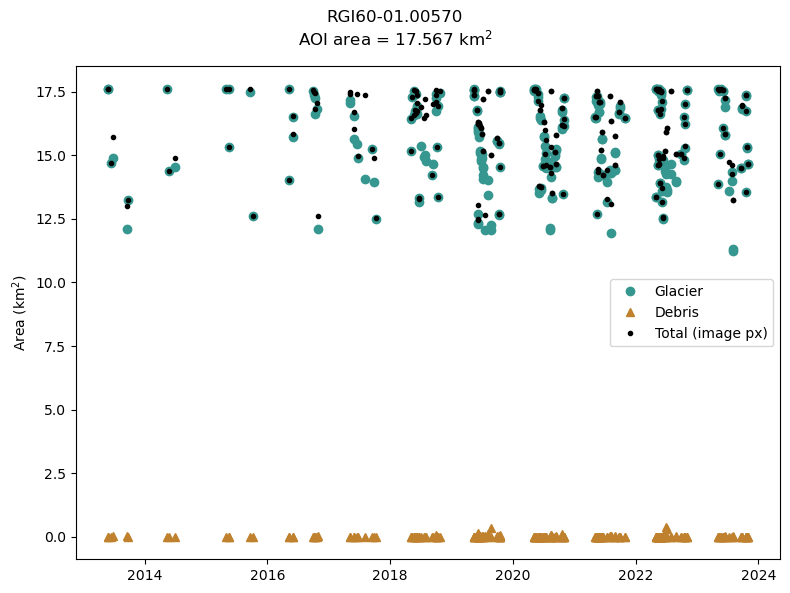

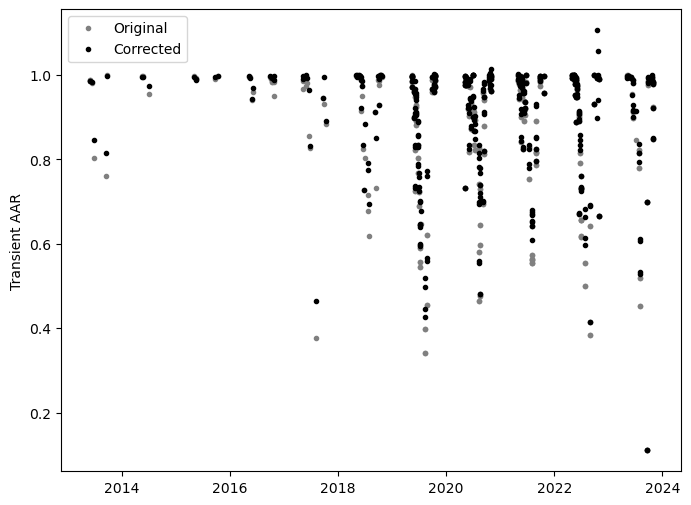

In [74]:
# Subset AOI
aoi = aois.loc[aois['Name'] == 'Gulkana Glacier']
aoi.reset_index(drop=True, inplace=True)

# Check for debris cover using classified images
classified_folder = os.path.join(data_path, aoi['RGIId'].values[0], 'classified')
df = estimate_glacier_debris_areas(aoi, classified_folder)

# Assess how updated areas would impact the transient AAR time series
# load snow cover stats
rgi_id = aoi['RGIId'].values[0]
sc_stats_fn = os.path.join(data_path, rgi_id, f'{rgi_id}_snow_cover_stats.csv')
sc_stats = pd.read_csv(sc_stats_fn)
sc_stats['datetime'] = pd.to_datetime(sc_stats['datetime'])
# merge with area stats
sc_stats = sc_stats.merge(df, on='datetime')
sc_stats['AAR_adj'] = sc_stats['SCA_m2'] / sc_stats['glacier_area_m2']
# plot both time series
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(sc_stats['datetime'], sc_stats['AAR'], '.', color='gray', label='Original')
ax.plot(sc_stats['datetime'], sc_stats['AAR_adj'], '.', color='black', label='Corrected')
ax.legend(loc='best')
ax.set_ylabel('Transient AAR')
plt.show()